# SteadyCellPhenotype python interface


In [1]:
import operator
import numpy as np

from itertools import product
from functools import reduce

from steady_cell_phenotype.equation_system import *
from steady_cell_phenotype.poly import *

## Fitting a polynomial from a truth table



In [2]:
# list out the free variables in the formula

free_variables = ('A', 'B')

# create monomial objects corresponding to these strings
monomials = tuple(map(lambda v: Monomial.as_var(v), free_variables))

monomials

(A, B)

Create a multi-state "truth table" of the form: list of (input-tuple, output) 
where the input tuple's is the values of taken corresponds to that of the free-variables tuple

In [3]:
truth_table = [
    ((0,0), 0),
    ((0,1), 1),
    ((0,2), 2),
    ((1,0), 1),
    ((1,1), 1),
    ((1,2), 1),
    ((2,0), 2),
    ((2,1), 1),
    ((2,2), 0),
]

# create the polynomial that interpolates the truth table:
# g(x) = sum_{c\in \F_3^n} h(c) prod_{j=0}^n (1-(x_j-c_j)**2)
expression = 0
for inputs, output in truth_table:
    expression += \
        output * \
        reduce(operator.mul,
               ( 1-(var-inpt)**2 
                 for var, inpt in zip(monomials, inputs) )
              )
    
expression

B+A+2*A*B

## Make a synchronous update function from an equation system

Creates a numpy based implementation of the equation system.

In [4]:
# create an equation system from a text-based update function
eqn_sys = EquationSystem.from_text("""
A=MIN(B,C)
B=C
C=NOT(A)
""")

eqn_sys

A=MIN(B,C)
B=C
C=NOT(A)

### Extract the update function as a numpy-based python callable.

The inputs of the function are a single tuple of values whose
meaning is given by the order of the variable names in the
`variable_names` tuple.

In [5]:
variable_names, update_fn = eqn_sys.as_numpy()

variable_names

('A', 'B', 'C')

In [6]:
# write the full system in truth-table form
for values in product(range(3), repeat=len(variable_names)):
    out_val = tuple(update_fn(values))
    print(values, '->', out_val)

(0, 0, 0) -> (0, 0, 2)
(0, 0, 1) -> (0, 1, 2)
(0, 0, 2) -> (0, 2, 2)
(0, 1, 0) -> (0, 0, 2)
(0, 1, 1) -> (1, 1, 2)
(0, 1, 2) -> (1, 2, 2)
(0, 2, 0) -> (0, 0, 2)
(0, 2, 1) -> (1, 1, 2)
(0, 2, 2) -> (2, 2, 2)
(1, 0, 0) -> (0, 0, 1)
(1, 0, 1) -> (0, 1, 1)
(1, 0, 2) -> (0, 2, 1)
(1, 1, 0) -> (0, 0, 1)
(1, 1, 1) -> (1, 1, 1)
(1, 1, 2) -> (1, 2, 1)
(1, 2, 0) -> (0, 0, 1)
(1, 2, 1) -> (1, 1, 1)
(1, 2, 2) -> (2, 2, 1)
(2, 0, 0) -> (0, 0, 0)
(2, 0, 1) -> (0, 1, 0)
(2, 0, 2) -> (0, 2, 0)
(2, 1, 0) -> (0, 0, 0)
(2, 1, 1) -> (1, 1, 0)
(2, 1, 2) -> (1, 2, 0)
(2, 2, 0) -> (0, 0, 0)
(2, 2, 1) -> (1, 1, 0)
(2, 2, 2) -> (2, 2, 0)


### Plot the update function as a state space graph.

Note: the web frontend has an interactive represenation

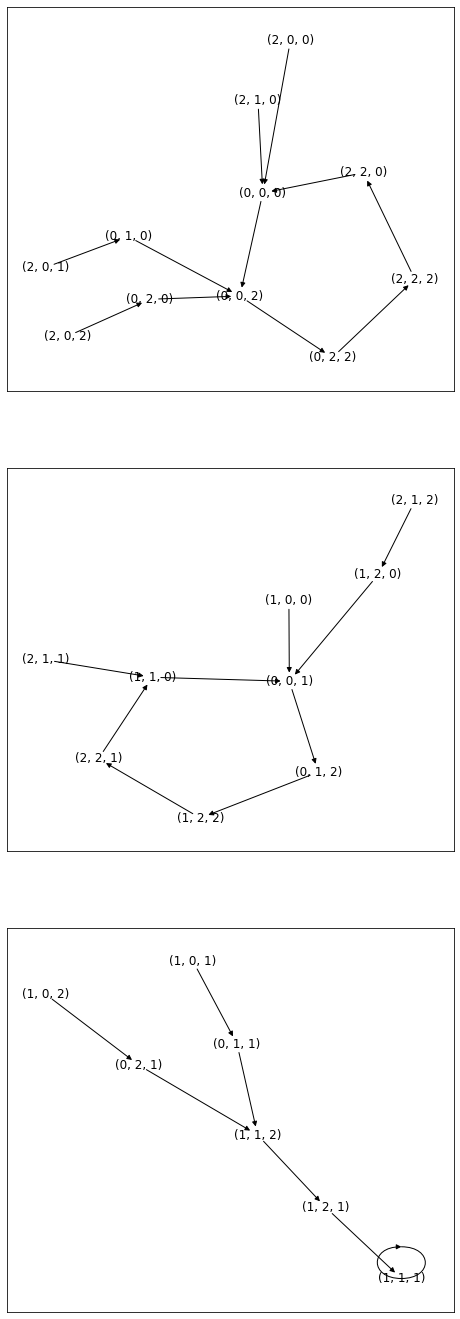

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# add edges to the graph
for values in product(range(3), repeat=len(variable_names)):
    out_val = tuple(update_fn(values))
    G.add_edge(values,out_val)

# plot the graph, divided by attractors
weak_components = [G.subgraph(c).copy()
                   for c in nx.weakly_connected_components(G)]
num_components = len(weak_components)
fig, axs = plt.subplots(nrows=num_components,
                        figsize=(8,num_components*8))
for idx, Gcomp in enumerate(weak_components):
    # kamada-kawai gives a reasonable layout, but puts some
    # points on top of each other. a small number of spring
    # layout iterations can resolve that.
    layout = nx.spring_layout(Gcomp, 
                              pos=nx.kamada_kawai_layout(Gcomp),
                              k=0.25,
                              iterations=2)
    nx.draw_networkx_edges(Gcomp, pos=layout, ax=axs[idx])
    nx.draw_networkx_labels(Gcomp, pos=layout, ax=axs[idx])
plt.show()

### The update function supports broadcasting

In [8]:
sample = np.random.randint(3,
                           size=(len(variable_names),20))

for _ in range(10):
    print(sample)
    print()
    sample[:] = update_fn(sample)
    
print(sample)

[[0 0 2 2 1 0 2 1 0 0 0 0 0 2 0 2 2 0 2 1]
 [2 0 1 1 1 0 2 1 2 1 2 1 0 2 2 0 2 2 1 1]
 [2 2 0 0 2 1 1 0 1 0 1 0 1 1 1 0 2 1 0 2]]

[[2 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 2 1 0 1]
 [2 2 0 0 2 1 1 0 1 0 1 0 1 1 1 0 2 1 0 2]
 [2 2 0 0 1 2 0 1 2 2 2 2 2 0 2 0 0 2 0 1]]

[[2 2 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1]
 [2 2 0 0 1 2 0 1 2 2 2 2 2 0 2 0 0 2 0 1]
 [0 2 2 2 1 2 1 2 1 2 1 2 2 1 1 2 0 1 2 1]]

[[0 2 0 0 1 2 0 1 1 2 1 2 2 0 1 0 0 1 0 1]
 [0 2 2 2 1 2 1 2 1 2 1 2 2 1 1 2 0 1 2 1]
 [0 0 2 2 1 1 2 2 1 2 1 2 1 2 1 2 2 1 2 1]]

[[0 0 2 2 1 1 1 2 1 2 1 2 1 1 1 2 0 1 2 1]
 [0 0 2 2 1 1 2 2 1 2 1 2 1 2 1 2 2 1 2 1]
 [2 0 2 2 1 0 2 1 1 0 1 0 0 2 1 2 2 1 2 1]]

[[0 0 2 2 1 0 2 1 1 0 1 0 0 2 1 2 2 1 2 1]
 [2 0 2 2 1 0 2 1 1 0 1 0 0 2 1 2 2 1 2 1]
 [2 2 0 0 1 1 1 0 1 0 1 0 1 1 1 0 2 1 0 1]]

[[2 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 2 1 0 1]
 [2 2 0 0 1 1 1 0 1 0 1 0 1 1 1 0 2 1 0 1]
 [2 2 0 0 1 2 0 1 1 2 1 2 2 0 1 0 0 1 0 1]]

[[2 2 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1]
 [2 2 0 0 1 2 0 1 1 2 1 2 2 0 1 0 0 1 0 

## The continuous version of an equation system

We can apply continuity via the continuity control function.

(the numpy update function can be faster this way)

In [9]:
eqn_sys.continuous_functional_system()

A=CONT(A,MIN(B,C))
B=CONT(B,C)
C=CONT(C,NOT(A))

#### Getting the continuous version of the system as a polynomial

In [10]:
eqn_sys_cont = eqn_sys.continuous_polynomial_system()

eqn_sys_cont

A=B^2*C^2+A+2*A*B^2*C^2+2*A^2+A^2*B*C+2*A^2*B*C^2+2*A^2*B^2*C+2*A^2*B^2*C^2
B=C^2+B+2*B^2+B^2*C+2*B*C^2
C=1+2*A+A^2+A*C+C^2+2*A*C^2+2*A^2*C

#### The update table for the continuous system

In [11]:
variable_names, cont_update_fn = eqn_sys_cont.as_numpy()

for values in product(range(3),
                      repeat=len(variable_names)):
    out_val = update_fn(values)
    out_val_cont = cont_update_fn(values)
    print(values,
          '-update->',
          out_val,
          '-continuity->',
          out_val_cont)

(0, 0, 0) -update-> [0 0 2] -continuity-> [0 0 1]
(0, 0, 1) -update-> [0 1 2] -continuity-> [0 1 2]
(0, 0, 2) -update-> [0 2 2] -continuity-> [0 1 2]
(0, 1, 0) -update-> [0 0 2] -continuity-> [0 0 1]
(0, 1, 1) -update-> [1 1 2] -continuity-> [1 1 2]
(0, 1, 2) -update-> [1 2 2] -continuity-> [1 2 2]
(0, 2, 0) -update-> [0 0 2] -continuity-> [0 1 1]
(0, 2, 1) -update-> [1 1 2] -continuity-> [1 1 2]
(0, 2, 2) -update-> [2 2 2] -continuity-> [1 2 2]
(1, 0, 0) -update-> [0 0 1] -continuity-> [0 0 1]
(1, 0, 1) -update-> [0 1 1] -continuity-> [0 1 1]
(1, 0, 2) -update-> [0 2 1] -continuity-> [0 1 1]
(1, 1, 0) -update-> [0 0 1] -continuity-> [0 0 1]
(1, 1, 1) -update-> [1 1 1] -continuity-> [1 1 1]
(1, 1, 2) -update-> [1 2 1] -continuity-> [1 2 1]
(1, 2, 0) -update-> [0 0 1] -continuity-> [0 1 1]
(1, 2, 1) -update-> [1 1 1] -continuity-> [1 1 1]
(1, 2, 2) -update-> [2 2 1] -continuity-> [2 2 1]
(2, 0, 0) -update-> [0 0 0] -continuity-> [1 0 0]
(2, 0, 1) -update-> [0 1 0] -continuity-> [1 1 0]


#### Ploting the _continuous_ update function as a state space graph

Note that fixed points of the usual update function remain so under continuity, but there can be significant changes to the cyclic attractors.

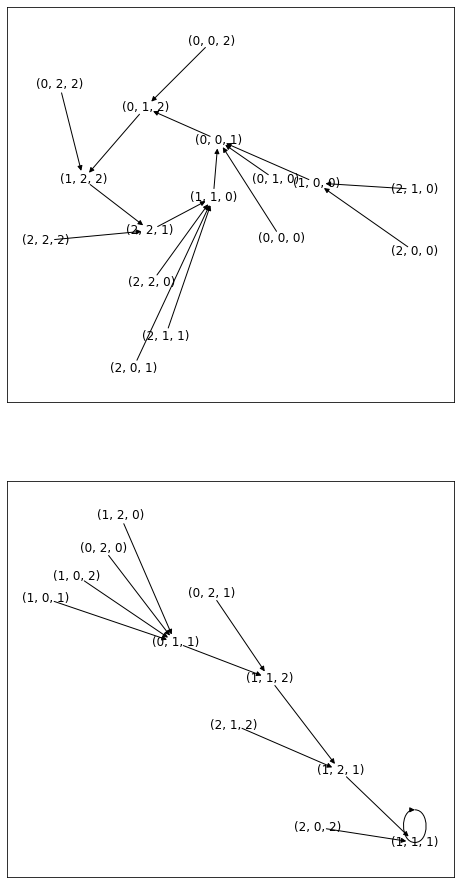

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# add edges to the graph
for values in product(range(3), repeat=len(variable_names)):
    out_val = tuple(cont_update_fn(values))
    G.add_edge(values,out_val)

# plot the graph, divided by attractors
weak_components = [G.subgraph(c).copy()
                   for c in nx.weakly_connected_components(G)]
num_components = len(weak_components)
fig, axs = plt.subplots(nrows=num_components,
                        figsize=(8,num_components*8))
for idx, Gcomp in enumerate(weak_components):
    # kamada-kawai gives a reasonable layout, but puts some
    # points on top of each other. a small number of spring
    # layout iterations can resolve that.
    layout = nx.spring_layout(Gcomp, 
                              pos=nx.kamada_kawai_layout(Gcomp),
                              k=0.25,
                              iterations=4)
    nx.draw_networkx_edges(Gcomp, pos=layout, ax=axs[idx])
    nx.draw_networkx_labels(Gcomp, pos=layout, ax=axs[idx])
plt.show()

## Loading models from files

In [13]:
# loading from text

with open('../models/model4.txt') as file:
    eqn_sys_from_file = EquationSystem.from_text(file.read())
    
eqn_sys_from_file

alpha=MIN(beta,alpha)
beta=MAX(alpha,gamma)
gamma=alpha+beta

In [14]:
# loading from sbml-qual

with open('../models/test-sbml-qual.sbml') as file:
    eqn_sys_from_sbml = EquationSystem.from_sbml_qual(file.read())
    
eqn_sys_from_sbml

G0=G0
G1=G0
G2=2*G1+2*G0+G0^2*G1+2*G1^2+G0^2+G0*G1^2